In [28]:
# Import required libraries
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.version)
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)
import pandas as pd

<module 'tensorflow.compat.v1.version' from 'C:\\Users\\mattr\\anaconda3\\envs\\mc\\lib\\site-packages\\tensorflow\\_api\\v2\\compat\\v1\\version\\__init__.py'>


In [29]:
# path = Path('./tsla.csv')
df = pd.read_csv('./aapl.csv', index_col='Date', infer_datetime_format=True, parse_dates=True)

In [30]:
# drop empty column
# df.drop(columns=['Down', 'RSI(14)', 'Up'], inplace=True)
# drop null values
df.dropna(inplace=True)
df = df.iloc[:1024]
df

,Open,High,Low,Close,Volume
Date,,,,,
2022-04-08,171.7800,171.7800,169.200,170.0900,76575508
2022-04-07,171.1600,173.3600,169.850,172.1399,77594650
2022-04-06,172.3600,173.6300,170.130,171.8300,89058782
2022-04-05,177.5000,178.3000,174.415,175.0600,73401786
2022-04-04,174.5700,178.4900,174.440,178.4400,76545983
...,...,...,...,...,...
2018-03-23,42.0975,42.4800,41.235,41.2350,164115136
2018-03-22,42.5000,43.1700,42.150,42.2125,165963068
2018-03-21,43.7600,43.7725,42.815,42.8175,148219740


In [31]:
minmax = MinMaxScaler().fit(df.iloc[:, 3:4].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 3:4].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.918614
1,0.932610
2,0.930494
3,0.952548
4,0.975625


In [32]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1024, 5), (994, 1), (30, 1))

In [33]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [34]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 100
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [35]:
def forecast():
    tf.compat.v1.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [36]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


C:\Users\mattr\AppData\Local\Temp\ipykernel_3780\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and 

simulation 2



C:\Users\mattr\AppData\Local\Temp\ipykernel_3780\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 3



C:\Users\mattr\AppData\Local\Temp\ipykernel_3780\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 4



C:\Users\mattr\AppData\Local\Temp\ipykernel_3780\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 5



C:\Users\mattr\AppData\Local\Temp\ipykernel_3780\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 6



C:\Users\mattr\AppData\Local\Temp\ipykernel_3780\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 7



C:\Users\mattr\AppData\Local\Temp\ipykernel_3780\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 8



C:\Users\mattr\AppData\Local\Temp\ipykernel_3780\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 9



C:\Users\mattr\AppData\Local\Temp\ipykernel_3780\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 10



C:\Users\mattr\AppData\Local\Temp\ipykernel_3780\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

[[55.50447784165115, 53.9507113321739, 55.92105494478018, 54.52533150115461, 55.45681289812707, 55.34016460490028, 54.380118633012046, 50.80425881135966, 52.84887746458248, 55.72206464071947, 53.61285644024601, 53.166436451243484, 52.40295418642873, 53.9100351812881, 55.421610856725515, 54.3533692087532, 53.46873462432748, 53.0820384687852, 53.247344514112854, 53.121796648485216, 54.20550532973956, 54.54367690933435, 55.00361772444708, 55.02383697813599, 53.69790561463096, 54.0429264602454, 51.125507370814425, 53.364483635549234, 53.832549387112564, 53.80033642660944], [52.2262860986021, 54.12915581061027, 54.13075051202087, 60.431304496985504, 64.66532605803886, 67.19910754112911, 64.26312729226062, 61.35982366677447, 60.47101933029291, 57.752553904353434, 59.460253335535214, 60.60112030223715, 60.857672082969785, 62.46733782305705, 61.658352297532446, 60.52405923168422, 59.17310929299622, 58.1114840056611, 56.1153244781715, 53.15830190776227, 57.388394602345706, 61.629918938390766, 6

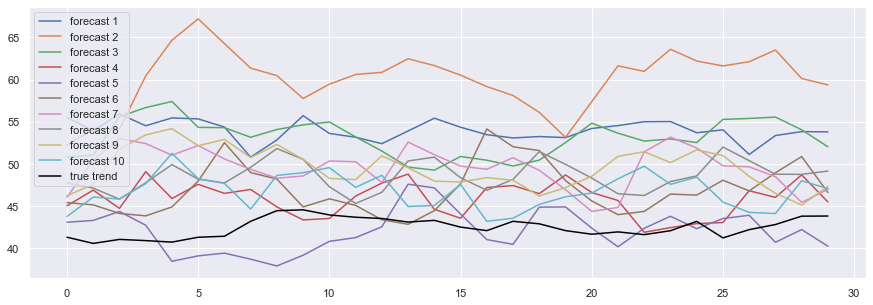

In [40]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]
print(results)
plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.show()